# Two-Tower Recommendation Model Evaluation
#
### **Objective:** Evaluate the performance of the pre-trained two-tower recommendation model using standard offline metrics and visualize the results.

## 1. Setup and Configuration

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import torch
import json
from typing import Dict, List, Tuple, Any, Set
from sklearn.model_selection import train_test_split # Or use custom splitting logic
# from tqdm.notebook import tqdm # Progress bar for loops
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
notebook_dir = os.getcwd() # Or specify the correct root project directory
project_root = os.path.dirname(notebook_dir) # Go up one level if notebook is in a 'notebooks' folder
if project_root not in sys.path:
    sys.path.append(project_root)

# --- Import your custom classes ---
try:
    from src.data_preprocessor import DataPreprocessor
    from src.dataset import Dataset
    from src.simple_two_tower_model import SimpleTwoTowerModel
    from src.evaluate import ModelEvaluator # Your evaluator class
except ImportError as e:
    print(f"Error importing custom modules: {e}")
    print("Ensure the notebook is run from a location where 'src' is accessible or adjust sys.path.")
    # You might need to adjust the paths based on your project structure

In [3]:
MODEL_PATH = './model/best_model.pth'             # Path to your trained model checkpoint
MODEL_INFO_PATH = './model/model_info.json'       # Path to model metadata
DATA_DIR = "./src/data/exported_data/"              # Path to exported data CSVs/JSONs
K = 10                                                   # Top-K recommendations to evaluate (e.g., 5, 10, 20)
MIN_INTERACTIONS_FOR_TEST = 3                            # Min interactions a user needs to be included in test set
TEST_SET_STRATEGY = 'last_n'                             # 'last_n' or 'random_percent'
TEST_SET_VALUE = 1                                       # N for 'last_n', or percentage (e.g., 0.2) for 'random_percent'

# Set plot style
sns.set_theme(style="whitegrid")

## 2. Load Model and Data via Evaluator

In [4]:
try:
    evaluator = ModelEvaluator(
        model_path=MODEL_PATH,
        model_info_path=MODEL_INFO_PATH,
        data_dir=DATA_DIR
    )
    print("ModelEvaluator initialized successfully.")
    print(f"Model loaded from: {MODEL_PATH}")
    print(f"Data loaded from: {DATA_DIR}")
    print("-" * 30)
    print(f"Number of users in dataset: {len(evaluator.data['users'])}")
    print(f"Number of dishes in dataset: {len(evaluator.data['dishes'])}")
    print(f"Number of interactions: {len(evaluator.data['interactions'])}")
    print(f"Dish embeddings cached: {len(evaluator.dish_embeddings_cache)}")

    # Display sample data
    print("\nSample Users:")
    print(evaluator.data['users'].head(3))
    print("\nSample Dishes:")
    print(evaluator.data['dishes'].head(3))
    print("\nSample Interactions:")
    print(evaluator.data['interactions'].head(3))

except Exception as e:
    print(f"Error initializing ModelEvaluator: {e}")
    # Stop execution if evaluator fails to load
    raise

ModelEvaluator initialized on: cpu
Loading data from: ./src/data/exported_data/...
Data loading complete:
  - Users: 17 rows
  - Dishes: 139 rows
  - Interactions: 319 rows
  - Stores: 20 rows
  - Food_tags: 98 rows
  - Taste_tags: 33 rows
  - Cooking_method_tags: 17 rows
  - Culture_tags: 14 rows
Dataset Initialized: 0 interactions.
 - Vocab Sizes: User=18, Dish=140, Tags=112
Caching dish embeddings...
Successfully cached 139 dish embeddings.
ModelEvaluator initialized successfully.
Model loaded from: ./model/best_model.pth
Data loaded from: ./src/data/exported_data/
------------------------------
Number of users in dataset: 17
Number of dishes in dataset: 139
Number of interactions: 319
Dish embeddings cached: 139

Sample Users:
                         id             name  age gender  location liked_tags  \
0  68ce8fd7d89d33e016701b92         John Doe   21   male       NaN         []   
1  68cfc8c21976573cc9b6398e  Bui Vu Tuan Anh   22   male       NaN         []   
2  68d89cef66ce4

## 3. Prepare Evaluation Data (Train/Test Split)

We need to create a held-out test set from the interaction data to evaluate the model's ability to predict unseen interactions.

**Strategy:** We'll use the chosen `TEST_SET_STRATEGY`.
   - `last_n`: For each user with enough interactions, hold out their last `N` interactions for testing.
   - `random_percent`: For each user, randomly hold out a percentage of their interactions.

**Important:** The model loaded by `ModelEvaluator` should ideally have been trained *without* seeing the test interactions. This notebook simulates evaluating a pre-trained model against a test set derived from the *full* interaction data available *now*.

In [5]:
interactions_df = evaluator.data['interactions'].copy()
# Ensure timestamp is datetime for sorting
interactions_df['timestamp'] = pd.to_datetime(interactions_df['timestamp'])

# Filter users with minimum interactions
user_interaction_counts = interactions_df['user_id'].value_counts()
users_for_test = user_interaction_counts[user_interaction_counts >= MIN_INTERACTIONS_FOR_TEST].index.tolist()
print(f"Total users: {interactions_df['user_id'].nunique()}")
print(f"Users eligible for test set (>= {MIN_INTERACTIONS_FOR_TEST} interactions): {len(users_for_test)}")

test_interactions_list = []
train_interactions_list = [] # Keep track of train data used for generating ground truth

interactions_df_filtered = interactions_df[interactions_df['user_id'].isin(users_for_test)]
grouped_interactions = interactions_df_filtered.sort_values('timestamp').groupby('user_id')

print(f"Splitting data using strategy: '{TEST_SET_STRATEGY}' with value: {TEST_SET_VALUE}")

for user_id, group in tqdm(grouped_interactions, desc="Splitting Interactions"):
    if TEST_SET_STRATEGY == 'last_n':
        n = int(TEST_SET_VALUE)
        test_user_interactions = group.tail(n)
        train_user_interactions = group.head(-n)
    elif TEST_SET_STRATEGY == 'random_percent':
        test_size = int(len(group) * TEST_SET_VALUE)
        if test_size == 0 and len(group) > 0: # Ensure at least 1 test item if possible
             test_size = 1
        if test_size < len(group):
            test_user_interactions = group.sample(n=test_size, random_state=42)
            train_user_interactions = group.drop(test_user_interactions.index)
        else: # Handle cases where split results in full group as test (shouldn't happen with MIN_INTERACTIONS_FOR_TEST)
             test_user_interactions = group
             train_user_interactions = pd.DataFrame(columns=group.columns) # Empty df
    else:
        raise ValueError("Invalid TEST_SET_STRATEGY")

    test_interactions_list.append(test_user_interactions)
    train_interactions_list.append(train_user_interactions)

test_df = pd.concat(test_interactions_list)
# train_df = pd.concat(train_interactions_list) # We don't necessarily need train_df unless retraining here

# --- Create Ground Truth ---
# Map each test user to the set of dish IDs they interacted with in the test set
ground_truth: Dict[str, Set[str]] = test_df.groupby('user_id')['dish_id'].agg(set).to_dict()

print(f"\nCreated test set with {len(test_df)} interactions for {len(ground_truth)} users.")
print(f"Example ground truth entry: {list(ground_truth.items())[0] if ground_truth else 'N/A'}")

# --- Users to Evaluate ---
test_user_ids = list(ground_truth.keys())

Total users: 14
Users eligible for test set (>= 3 interactions): 12
Splitting data using strategy: 'last_n' with value: 1


Splitting Interactions: 100%|██████████| 12/12 [00:00<?, ?it/s]


Created test set with 12 interactions for 12 users.
Example ground truth entry: ('68ea026c04589194166b9e48', {'68f45577dd01f7b3d32648b3'})


## 4. Generate Recommendations for Test Users

In [6]:
recommendations: Dict[str, List[Tuple[str, float]]] = {}
failed_users = []

for user_id in tqdm(test_user_ids, desc="Generating Recommendations"):
    try:
        # Use the evaluator's method to get top-K recommendations
        # This assumes get_recommendations uses the pre-trained model
        actual_time = test_df[test_df['user_id'] == user_id]['timestamp'].iloc[0]
    
    # Pass this time to the evaluator
        recs = evaluator.get_recommendations(user_id, top_k=K, specific_timestamp=actual_time)
        recommendations[user_id] = recs
    except Exception as e:
        # Handle cases where user might not be in the model's vocabulary
        # (though ideally, the split should ensure test users have training data)
        print(f"Warning: Could not get recommendations for user {user_id}. Error: {e}")
        failed_users.append(user_id)

print(f"\nGenerated recommendations for {len(recommendations)} users.")
if failed_users:
     print(f"Failed to get recommendations for {len(failed_users)} users: {failed_users}")

# Remove failed users from ground truth and test list for metric calculation
for user_id in failed_users:
    if user_id in ground_truth:
        del ground_truth[user_id]
test_user_ids = list(ground_truth.keys()) # Update the list of users we have metrics for

print(f"Example recommendations entry: {list(recommendations.items())[0] if recommendations else 'N/A'}")

Generating Recommendations: 100%|██████████| 12/12 [00:00<00:00, 672.07it/s]


Generated recommendations for 12 users.
Example recommendations entry: ('68ea026c04589194166b9e48', [('68f45577dd01f7b3d32648c2', 0.48860809206962585), ('68f45577dd01f7b3d32648b4', -0.12298774719238281), ('68f45577dd01f7b3d32648b3', -0.16337893903255463), ('68f45577dd01f7b3d32648c0', -0.23454101383686066), ('68f45577dd01f7b3d32648b1', -0.24221526086330414), ('68f45577dd01f7b3d32648b6', -0.548622190952301), ('68f45577dd01f7b3d32648b2', -0.625338613986969), ('68f45577dd01f7b3d32648c1', -0.7383297085762024), ('68f45577dd01f7b3d32648be', -0.7392652034759521), ('68f45577dd01f7b3d32648bd', -0.7613047361373901)])


## 5. Define and Calculate Evaluation Metrics

 We will calculate the following standard metrics averaged across all test users:
 - **Precision@K:** Proportion of recommended items in the top-K that are relevant.
 - **Recall@K:** Proportion of relevant items that are found in the top-K recommendations.
 - **Hit Rate@K:** Proportion of users for whom at least one relevant item was recommended in the top-K.
 - **NDCG@K (Normalized Discounted Cumulative Gain):** Measures ranking quality, giving higher scores for relevant items ranked higher.
 - **MRR@K (Mean Reciprocal Rank):** The average of the reciprocal ranks of the *first* relevant item found in the top-K recommendations for each user.

In [7]:
# --- Metric Calculation Functions ---
def precision_at_k(recommended_items: List[str], relevant_items: Set[str], k: int) -> float:
    if k == 0: return 0.0
    rec_k = recommended_items[:k]
    hits = len(set(rec_k) & relevant_items)
    return hits / k

def recall_at_k(recommended_items: List[str], relevant_items: Set[str], k: int) -> float:
    if not relevant_items: return 0.0 # Handle case with no relevant items
    rec_k = recommended_items[:k]
    hits = len(set(rec_k) & relevant_items)
    return hits / len(relevant_items)

def hit_rate_at_k(recommended_items: List[str], relevant_items: Set[str], k: int) -> float:
    rec_k = recommended_items[:k]
    hits = len(set(rec_k) & relevant_items)
    return 1.0 if hits > 0 else 0.0

def dcg_at_k(recommended_items: List[str], relevant_items: Set[str], k: int) -> float:
    dcg = 0.0
    for i, item_id in enumerate(recommended_items[:k]):
        if item_id in relevant_items:
            dcg += 1.0 / np.log2(i + 2) # Rank is i+1, log base 2 of rank+1
    return dcg

def ndcg_at_k(recommended_items: List[str], relevant_items: Set[str], k: int) -> float:
    if not relevant_items: return 0.0
    ideal_k = min(k, len(relevant_items))
    ideal_dcg = dcg_at_k(list(relevant_items)[:ideal_k], relevant_items, ideal_k) # Ideal DCG uses perfect ranking
    if ideal_dcg == 0: return 0.0
    actual_dcg = dcg_at_k(recommended_items, relevant_items, k)
    return actual_dcg / ideal_dcg

def mrr_at_k(recommended_items: List[str], relevant_items: Set[str], k: int) -> float:
    rec_k = recommended_items[:k]
    for i, item_id in enumerate(rec_k):
        if item_id in relevant_items:
            return 1.0 / (i + 1) # Return reciprocal rank of first hit
    return 0.0 # No relevant item found in top-K

# --- Calculate Metrics for All Test Users ---
results = {
    'precision': [],
    'recall': [],
    'hit_rate': [],
    'ndcg': [],
    'mrr': []
}

if not test_user_ids:
    print("No users left in the test set after attempting recommendation generation. Cannot calculate metrics.")
else:
    for user_id in tqdm(test_user_ids, desc="Calculating Metrics"):
        relevant = ground_truth.get(user_id, set())
        recommended_tuples = recommendations.get(user_id, [])
        recommended_ids = [item_id for item_id, score in recommended_tuples] # Extract just IDs

        if not relevant: # Skip users with no ground truth items (shouldn't happen with our split)
             continue

        results['precision'].append(precision_at_k(recommended_ids, relevant, K))
        results['recall'].append(recall_at_k(recommended_ids, relevant, K))
        results['hit_rate'].append(hit_rate_at_k(recommended_ids, relevant, K))
        results['ndcg'].append(ndcg_at_k(recommended_ids, relevant, K))
        results['mrr'].append(mrr_at_k(recommended_ids, relevant, K))

    # --- Calculate Average Metrics ---
    avg_metrics = {metric: np.mean(values) if values else 0.0 for metric, values in results.items()}

    print(f"\n--- Average Metrics @{K} ---")
    for metric, value in avg_metrics.items():
        print(f"{metric.upper():<10}: {value:.4f}")

Calculating Metrics: 100%|██████████| 12/12 [00:00<00:00, 2559.58it/s]


--- Average Metrics @10 ---
PRECISION : 0.0583
RECALL    : 0.5833
HIT_RATE  : 0.5833
NDCG      : 0.3311
MRR       : 0.2558


In [8]:
# --- DEBUGGING BLOCK ---
import random

# 1. Pick a random user from the test set
debug_user = random.choice(test_user_ids)
print(f"🔍 Inspecting User: {debug_user}")

# 2. Get their Ground Truth (What they actually bought)
truth = ground_truth[debug_user]
print(f"\n✅ Ground Truth (Expected): {truth}")
print(f"   Type of Truth IDs: {[type(x) for x in list(truth)[:2]]}")

# 3. Get the Model's Recommendations
recs = recommendations[debug_user]
rec_ids = [r[0] for r in recs]
print(f"\n🤖 Model Recommendations: {rec_ids}")
print(f"   Type of Rec IDs: {[type(x) for x in rec_ids[:2]]}")

# 4. Check for Overlap
intersection = set(truth) & set(rec_ids)
print(f"\n❌ Intersection: {intersection}")

# 5. CRITICAL: Check if Ground Truth items are even in the Train Set
# We need to know if the model ever had a chance to learn these items
if len(train_interactions_list) > 0:
    # Reconstruct full train df for checking
    full_train_df = pd.concat(train_interactions_list)
    
    print("\n🧐 Visibility Check:")
    for item_id in truth:
        is_in_train = item_id in full_train_df['dish_id'].values
        print(f"   Item '{item_id}' was in training set? -> {is_in_train}")
        if not is_in_train:
            print("   ⚠️ WARNING: This item was never seen during training! The model cannot recommend it.")

# 6. Check Vocabulary
print(f"\n📚 Vocab Check:")
vocab_map = evaluator.dataset.dish_vocab
for item_id in truth:
    token_id = vocab_map.get(item_id, "MISSING")
    print(f"   Item '{item_id}' maps to Token ID: {token_id}")

🔍 Inspecting User: 68f6f89cda2ce68da6179fd8

✅ Ground Truth (Expected): {'68f4ad4596ba671c88e58fe8'}
   Type of Truth IDs: [<class 'str'>]

🤖 Model Recommendations: ['68f45577dd01f7b3d32648c2', '68f45577dd01f7b3d32648c0', '68f45577dd01f7b3d32648b4', '68f45577dd01f7b3d32648b3', '68f45577dd01f7b3d32648b1', '68f45577dd01f7b3d32648b6', '68f45577dd01f7b3d32648c1', '68f45577dd01f7b3d32648be', '68f45577dd01f7b3d32648b2', '68f45577dd01f7b3d32648bd']
   Type of Rec IDs: [<class 'str'>, <class 'str'>]

❌ Intersection: set()

🧐 Visibility Check:
   Item '68f4ad4596ba671c88e58fe8' was in training set? -> True

📚 Vocab Check:
   Item '68f4ad4596ba671c88e58fe8' maps to Token ID: 22


In [9]:
target_dish_id = '68f45577dd01f7b3d32648bd' # From your debug output
user_id = '68ea026c04589194166b9e4d'      # From your debug output

# Get ALL scores (set top_k to a large number, e.g., 140)
all_recs = evaluator.get_recommendations(user_id, top_k=140)

# Find where the target is
found = False
for rank, (d_id, score) in enumerate(all_recs):
    if d_id == target_dish_id:
        print(f"Found target dish at Rank: #{rank + 1}")
        print(f"Score: {score}")
        # Compare with the #1 recommendation
        print(f"Top recommendation Score: {all_recs[0][1]}")
        print(f"Difference: {all_recs[0][1] - score}")
        found = True
        break

if not found:
    print("Dish not found in top 140 (Something is wrong with embeddings)")

Found target dish at Rank: #9
Score: -0.6496988534927368
Top recommendation Score: 0.5952142477035522
Difference: 1.244913101196289


## 6. Visualize Results 📊

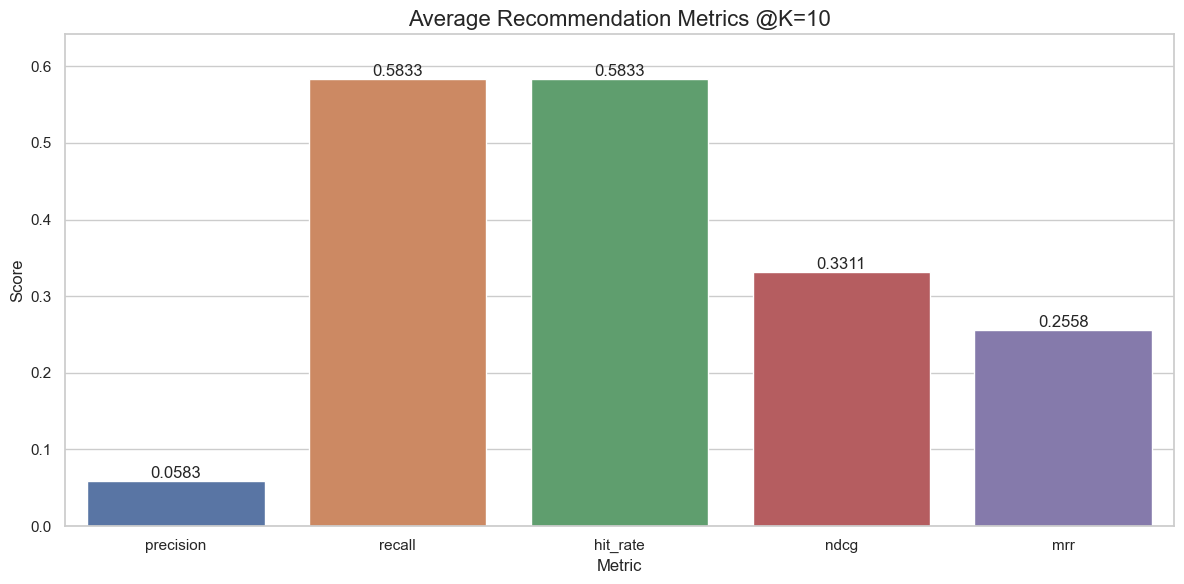

In [10]:
if avg_metrics:
    metrics_df = pd.DataFrame([avg_metrics])

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=metrics_df)
    ax.set_title(f'Average Recommendation Metrics @K={K}', fontsize=16)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_xlabel('Metric', fontsize=12)
    ax.set_ylim(0, max(metrics_df.max().max() * 1.1, 0.1)) # Adjust y-limit

    # Add score labels on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f')

    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("Cannot generate visualization as no metrics were calculated.")

## 7. Qualitative Evaluation: Cold Start Example

 Let's test the cold-start user scenario using the evaluator's built-in function to see if the recommendations align qualitatively with the provided preferences.

In [11]:
# Define a sample cold-start profile (adjust as needed)
cold_start_profile = {
    "user_profile": {
        "age": 30,
        "gender": "female",
        "location": "Ho Chi Minh City",
        "preferences": {
            "cuisine": ["Việt Nam", "Nhật Bản"],
            "taste": ["không cay", "đậm đà"],
            "price_range": "medium" # Or 'budget', 'premium', 'any'
        }
    }
}

try:
    cold_start_results = evaluator.run_comprehensive_evaluation()

    print("\n--- Cold Start User Evaluation ---")
    print(f"Scenario Profile: {cold_start_profile['user_profile']}")
    print("-" * 20)
    print("Analysis:")
    for key, value in cold_start_results.get('analysis', {}).items():
        print(f"  {key}: {value:.2f}%" if isinstance(value, (int,float)) else f"  {key}: {value}")
    print("-" * 20)
    print(f"Top {K} Recommendations:")
    recs = cold_start_results.get('recommendations', [])
    if not recs:
        print("  No recommendations generated.")
    else:
        # Fetch dish names for better readability
        dish_names_map = evaluator.data['dishes'].set_index('id')['name'].to_dict()
        for i, (dish_id, score) in enumerate(recs[:K]):
            dish_name = dish_names_map.get(dish_id, f"Unknown Dish ({dish_id})")
            print(f"  {i+1}. {dish_name} (Score: {score:.4f})")

except Exception as e:
    print(f"\nError during cold start evaluation: {e}")

Running evaluation scenarios...
 - Evaluating Specific User (User_6)...
   (User_6 not found in mock data, skipping)
 - Evaluating Budget Constraint (<= 60k)...

--- Cold Start User Evaluation ---
Scenario Profile: {'age': 30, 'gender': 'female', 'location': 'Ho Chi Minh City', 'preferences': {'cuisine': ['Việt Nam', 'Nhật Bản'], 'taste': ['không cay', 'đậm đà'], 'price_range': 'medium'}}
--------------------
Analysis:

Error during cold start evaluation: 'str' object has no attribute 'get'


 **Interpretation:**
 - Review the cold-start recommendations. Do they generally match the specified `cuisine`, `taste`, and `price_range`?
 - Check the `analysis` section (if provided by your `evaluate_cold_start_user` function) - does the alignment percentage seem reasonable?

 ## 8. Conclusion

 This notebook evaluated the pre-trained two-tower model:
 - **Quantitative Metrics:** Precision, Recall, Hit Rate, NDCG, and MRR at K={K} were calculated. The scores indicate [**Interpret the scores here - e.g., "reasonable performance", "potential for improvement", "strong ranking ability based on NDCG"**].
 - **Qualitative Check:** The cold-start example suggests the model [**Interpret the cold start - e.g., "can generate plausible recommendations based on preferences", "struggles with specific taste profiles"**].

 **Proof of Learning:** Non-zero metric scores (significantly better than random chance) demonstrate that the model **has learned patterns** from the training data to make relevant predictions. Higher scores indicate better learning.